In [4]:
%load_ext rpy2.ipython

import warnings
warnings.filterwarnings("ignore")
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    import pandas as pd
    import sys
    import os
    import glob
    import sqlite3

    %R options(warn=-1)
    
    # load R libraries
    %R library(rGREAT)
    %R library(stringr)
    %R library(ggplot2)
    %R library(gridExtra)
    %R library(reshape)
    %R library(reshape2)
    %R library()

    db = "csvdb"

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# GREAT Gene Ontology
- Differentially accessible peaks analysed using http://bejerano.stanford.edu/great/public/html/splash.php

In [39]:
%%R

# R plot theme
theme_notebook <- function(base_size=18, base_family="helvetica") {
                  (theme_set(theme_minimal(base_size=18))
                  + theme(plot.title = element_text(face="bold", size=20, hjust=0.5),
                             text = element_text(),
                             axis.title = element_text(face="bold",size = rel(1)),
                             axis.title.y = element_text(angle=90,vjust=2, size=20),
                             axis.title.x = element_text(vjust=-0.2, size=20),
                             axis.text = element_text(size=20),
                             axis.line = element_line(colour="black"),
                             axis.ticks = element_line(),
                             legend.key = element_rect(colour = NA),
                             legend.key.size= unit(0.5, "cm"),
                             legend.margin = unit(0.5, "cm"),
                             legend.text = element_text(size=14),
                             legend.title = element_text(size=16),
                             ))
}


# Set ggplot theme
theme_set(theme_notebook(base_size=18))

# get pretty colours
library(wesanderson)
Palette <- wes_palette(sample(names(wes_palettes), 1))

In [34]:
%%R

# GREAT GO Analysis functions

GREAT_GO <- function(bed, species) {
    
    # Get GO results from GREAT, using default gene association rule
    
    # returns info as a nested list
        # [1] GO MF
        # [2] GO BP
        # [3] GO CC
        # [4] Results (GreatJob object)
        # [5] Region-gene association (GRanges object)
    
    job = submitGreatJob(bed, species=species, request_interval=30) # submit job to server
    
    df = getEnrichmentTables(job)
    
    res = plotRegionGeneAssociationGraphs(job) # plot default graphs
    
    results = c(df, job, res)
    
}

subset_GO <- function(df, ontology){
    
    # subset GO results by ontology, calculate adjusted p value & remove non-significant hits
        
    # Enrichment tables:
    # [1] = GO Molecular Function
    # [2] = GO Biological Process
    # [3] = GO Cellular Component
    
    # Get results for specified ontology  
    if (ontology == "MF"){
        res =  df[[1]] 
        label <- "MolcularFunction"}
    else if (ontology == "BP"){
        res =  df[[2]] 
        label <- "BiologicalProcess"}
    else if (ontology == "CC"){
        res =  df[[3]] 
        label <- "CellularComponent"}
    else {
        print("Select GO table: MF, BP, or CC") }
    
    res["Ontology"] <- label
    
    # Adjust P value for multiple comparisons 
    res["AdjustedBinomPValue"] <- p.adjust(res$Binom_Raw_PValue, method = "bonferroni")
    res["FDR"] <- p.adjust(res$Binom_Raw_PValue, method = "BH")
    res = res[res$AdjustedBinomPValue < 0.05, ] # subset on padj
    res = res[order(res$Binom_Raw_PValue), ] # order results by padj
    
    return(res)
    
    # get top n GO results
    #res = res[1:no_hits, ]

}

getGO_genes <- function(GOjob, gene_ontology, GO_ID){
    
    # get genes in GO category an plot informative graphs
    
    genes = plotRegionGeneAssociationGraphs(GOjob,  ontology=gene_ontology, termID=GO_ID)

    print(genes)
}

In [71]:
n = 0
for i in glob.glob("DESeq2_peaks.dir/*bed"):
    n = n+1
    comp = i.replace("DESeq2_peaks.dir/DE_peaks_", "")[: -len("_decrease.bed")]
    direction = os.path.basename(i).split("_")[-1].replace(".bed", "")
    
    if n == 1:        
        beds = pd.read_csv(i, sep="\t", header=None).iloc[:, 0:4]
        beds.columns=["chr", "start", "end", "peak_id"]
        beds["comparison"] = comp
        beds["direction"] = direction
    else:
        df = pd.read_csv(i, sep="\t", header=None).iloc[:, 0:4]
        df.columns=["chr", "start", "end", "peak_id"]
        df["comparison"] = comp
        df["direction"] = direction
        beds = beds.append(df)

R[write to console]: Don't make too frequent requests. The time break is 30s.
Please wait for 13s for the next request.
The time break can be set by `request_interval` argument.




  |==================================================================    |  94%


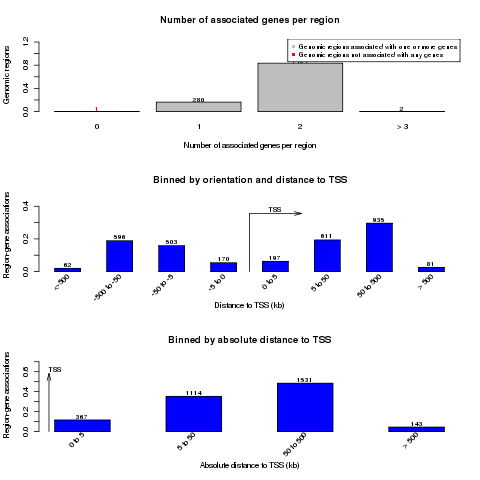

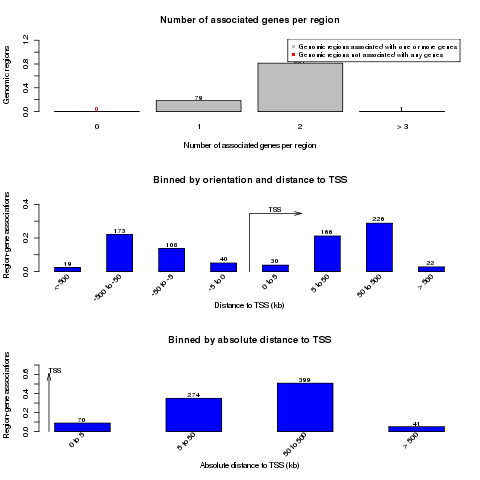

In [57]:
%%R -i beds

n <- 0
for (c in unique(beds$comparison)){
    n <- n +1
    
    bed <- subset(beds, comparison == c)
    bed_up <- subset(bed, direction == "increase")[1:4]
    bed_down <- subset(bed, direction == "decrease")[1:4]
    
    # run GREAT 
    bed_up_GO <- GREAT_GO(bed_up, "mm10")
    bed_up_GO$comparison <- c
    bed_up_GO$direction <- "increase"
    
    bed_down_GO <- GREAT_GO(bed_down, "mm10")
    bed_down_GO$comparison <- c
    bed_down_GO$direction <- "decrease"
    
    n2 <- 0
    direction <- c("increase", "decrease")
    for (bed in list(bed_up_GO, bed_down_GO)){
        n2 <- n2 +1
        
        # extract significant results & merge
        bed_MF <- subset_GO(bed, "MF")
        bed_BP <- subset_GO(bed, "BP")
        bed_CC <- subset_GO(bed, "CC")
    
        if (n2 == 1){
            bed_all <- rbind(bed_MF, bed_BP, bed_CC)
            bed_all <- bed_all[order(bed_all$AdjustedBinomPValue), ]
#             bed_all <- head(bed_all, 15) #limit to 15 top results
            bed_all$comparison <- c
            bed_all$direction <- direction[n2]
        } else{
            df <- rbind(bed_MF, bed_BP, bed_CC)
            df <- df[order(df$AdjustedBinomPValue), ]
#             df <- head(df, 15)
            df$comparison <- c
            df$direction <- direction[n2]
            bed_all <- rbind(bed_all, df)
        }
    }
    
    if (n == 1){
        bed_GO <- bed_all
    } else {
        bed_GO <- rbind(bed_GO, bed_all)
    }   
}

In [58]:
%%R

# Save dfs 
saveRDS(bed_GO, "DESeq2_peaks.dir/bed_GO.rds")
bed_GO <- readRDS("DESeq2_peaks.dir/bed_GO.rds")

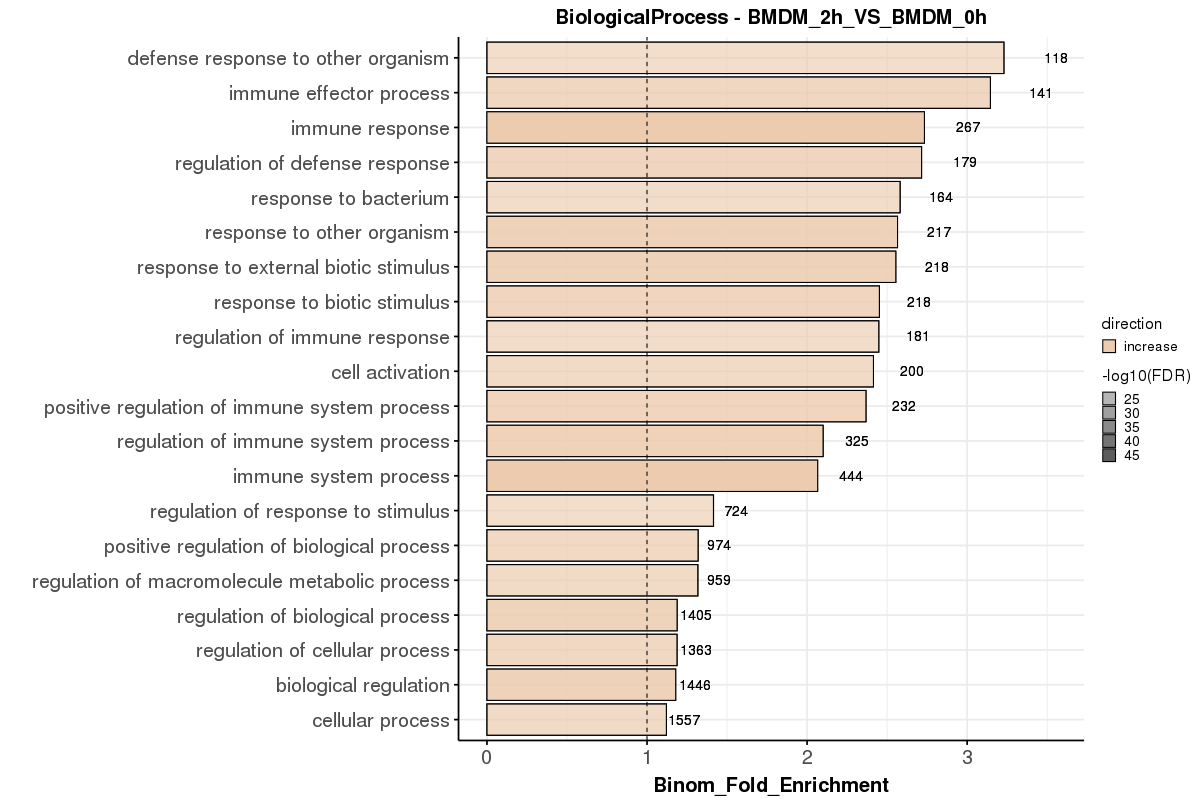

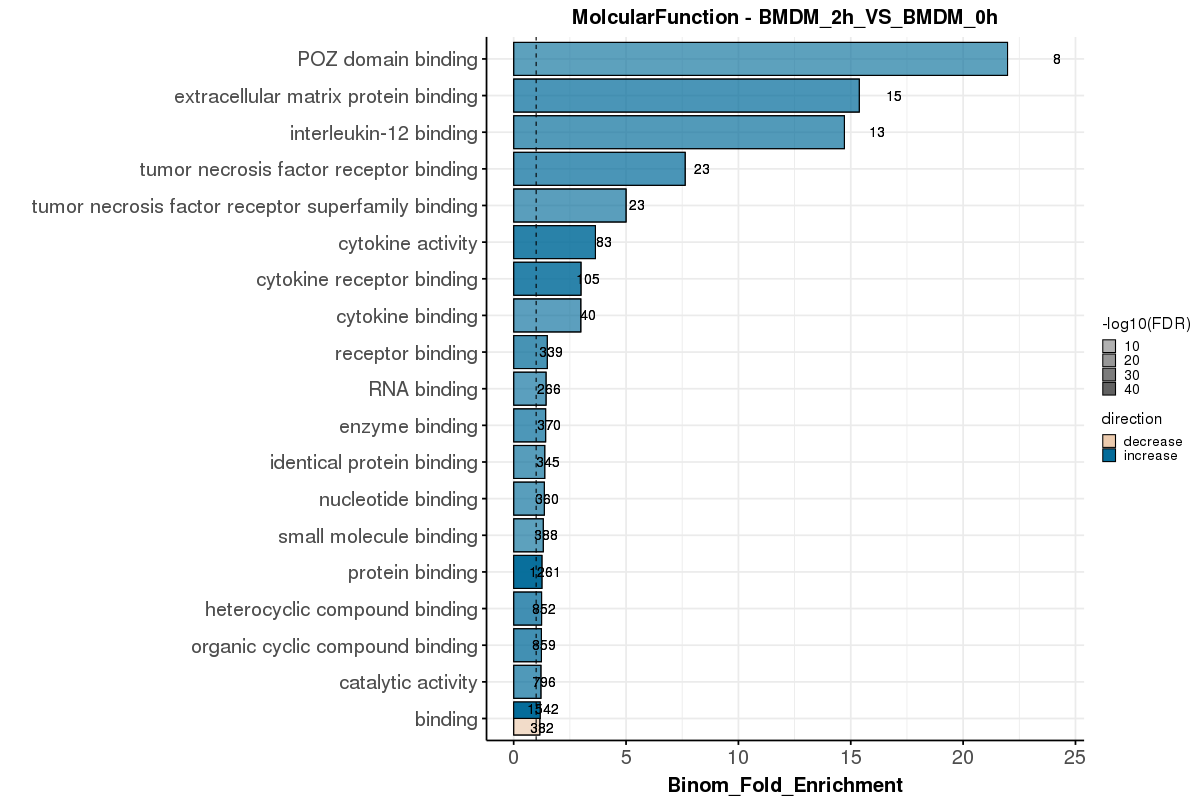

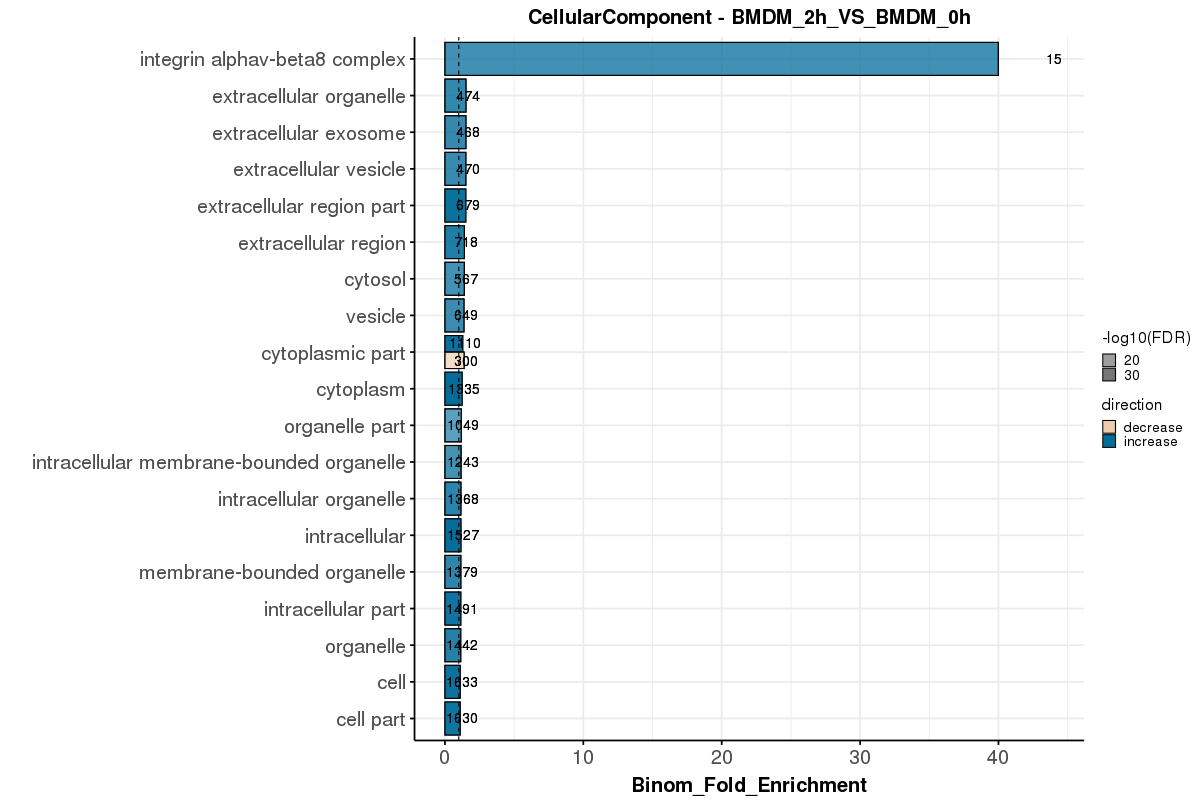

In [70]:
%%R -w 1200 -h 800

order_go <- function(go, limit=0, padj=0.05){
    
    go_df <- go

    go_df <- subset(go_df, FDR < padj)
    go_df <- go_df[order(go_df$FDR), ]
    
    if (limit!=0){
        go_df <- head(go_df, limit)
    }
    
    go_df <- go_df[order(-go_df$Binom_Fold_Enrichment), ]
    go_df <- go_df[rev(order(go_df$direction)), ]
    
    return(go_df)
}

n <- 0
for (c in unique(bed_GO$comparison)){
    n <- n +1
    df <- subset(bed_GO, comparison == c)
    
    for (o in unique(df$Ontology)){
    
        ont <- subset(df, Ontology == o)
        
        up <- order_go(subset(ont, direction="increase"), limit=20)
        down <- order_go(subset(ont, direction="decrease"), limit=20)
        plot <- rbind(up, down)
        
        p1 <- ggplot(plot, aes(y=Binom_Fold_Enrichment, x=name, fill=direction, alpha=-log10(FDR))) + 
                geom_bar(stat="identity", position="dodge", colour="black") + 
                scale_alpha(range=c(0.4, 1), name="-log10(FDR)") +
                geom_text(aes(label=Binom_Observed_Region_Hits, y=Binom_Fold_Enrichment+(Binom_Fold_Enrichment*0.1)), position=position_dodge(width=1), 
                          colour="black", alpha=1, size=5) +
                theme(axis.text.x = element_text(angle=60, hjust=1)) + 
                geom_hline(yintercept=1, linetype="dashed", colour="black") + 
                labs(x="", title=paste(o, "-", c)) +
                scale_fill_manual(values=Palette) +
                coord_flip() + 
                theme_notebook() +
                scale_x_discrete(limits=unique(plot$name), labels=unique(str_wrap(plot$name, 60)))


        grid.arrange(p1, ncol=1, nrow=1)
    }
}